# _Main Notebook_

## Table of Contents:

- [EDA](#eda)
  - [TODO](#subsection-1-1)
- [Communities analysis](#communities)
  - [Subsection 2.1](#subsection-2-1)
  - [Subsection 2.2](#subsection-2-2)
- [Content of edits analysis](#edits)

In [1]:
# Imports

import pandas as pd
import sys
sys.path.append('../')
from ada2023.utils import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gzip
from itertools import combinations
from scipy.stats import pearsonr

# Exploratory Data Analysis <a class="anchor" id="eda"></a>

# Communities Analysis <a class="anchor" id="communities"></a>

## Setup

We process the Wikipedia Request for Adminship (RfA) dataset into a dataframe. We are using a [Wikipedia edit history dataset](https://snap.stanford.edu/data/wiki-meta.html) containing edit up to january 2008. Therefore we filter votes that aren't present in this timeframe.

In [2]:
df = pd.read_csv("../data/wiki-RfA-cleaned.csv")

# We filter out all the votations after 2008 as we do not have the edits for those dates
df = df[df.year_election < 2009]

#Set of users that are present in the adminship dataset
admin_set = set(df['source'].to_list() + df['target'].to_list())

In [3]:
len(admin_set)

8494

We consider an interaction between two users to be an edit from user A in the user talk page of user B. User talk page ["normal use is for messages from, and discussion with, other editors"](https://en.wikipedia.org/wiki/Wikipedia:User_pages). We filtered edits to keep only interactions from users that where present in the RfA dataset. Using those interactions we created an undirected graph where the weight is the number of interaction between the two users and each node is a user. (TODO : Check with Jeremy for more precise explanation).

In [4]:
G = create_interaction_graph()

To have a better understanding of the interactions, we plot them in a graph. We also plot the degree rank plot and histogram. The degree of a node is the number of edges adjacents to the node. This plot helps us to better understand the distribution of the number of adjacent nodes. We can see that most of the nodes have a low rank. (TODO : Check avec Robin si ok)

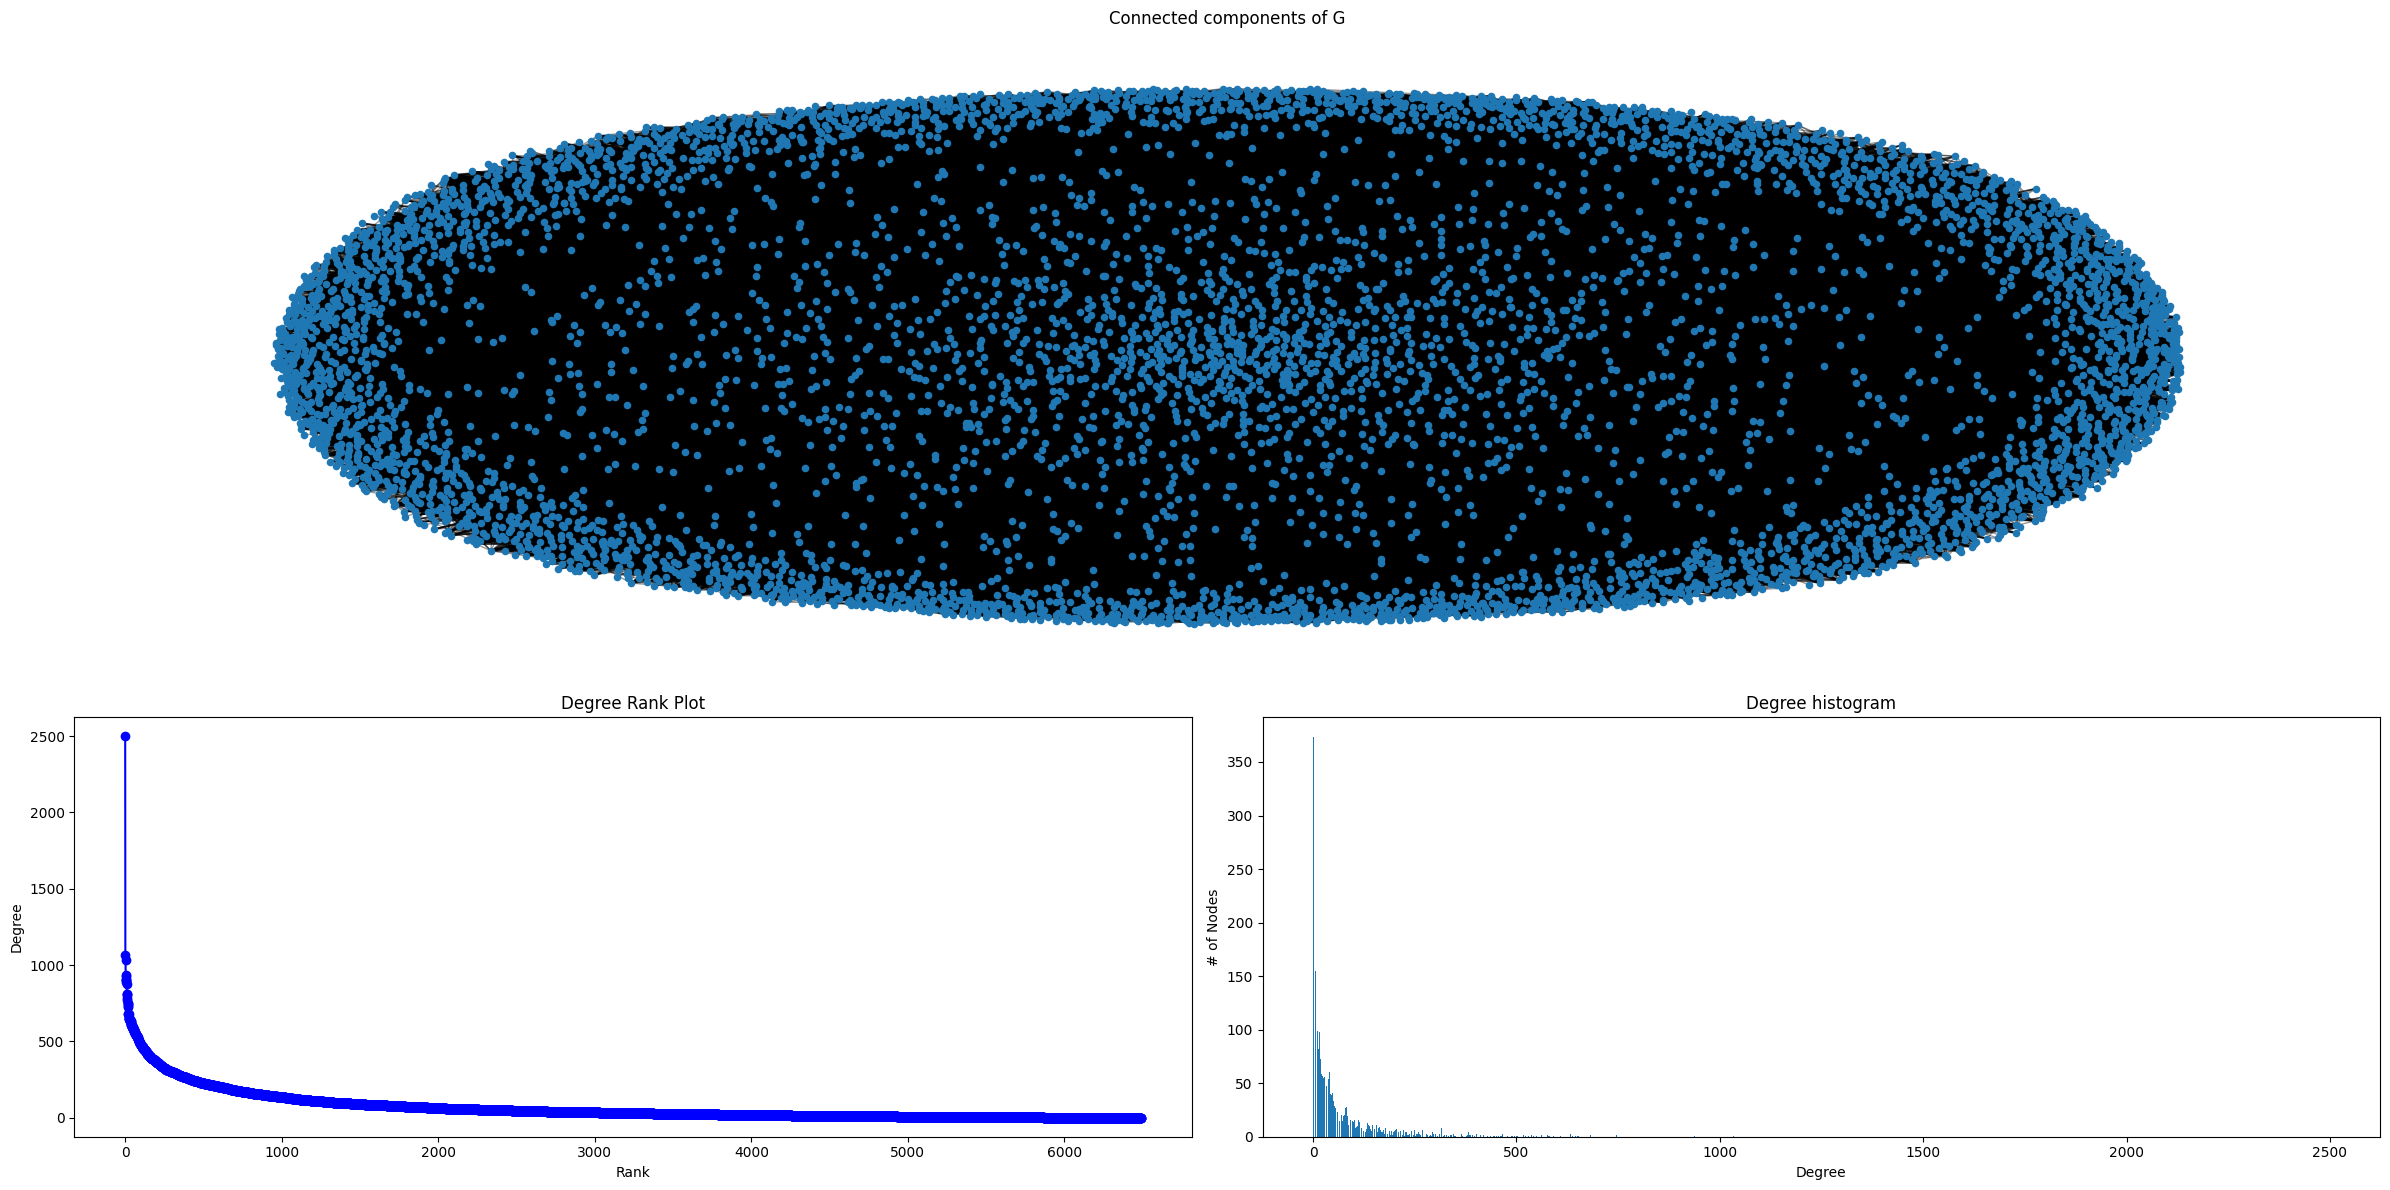

In [5]:
# We sort the nodes in the graph by their degree
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(24, 12))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

# Graph of the connected components
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, k=1, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

# Degree rank plot (TODO : demander si ylabel est bien "Degree" ou plutot "# of Nodes")
ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

# Degree histogram
ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [55]:
#We create the communities

# 3 paramètres qui donnent des résultats sympas
#communities = nx.community.louvain_communities(G, resolution=1.5, seed=2)
#communities = nx.community.louvain_communities(G, resolution=1.7, seed=3)
communities = nx.community.louvain_communities(G, resolution=1.2, seed=0)

In [56]:
print(f"Number of communities in graph of users with interactions : {len(communities)}")

Number of communities in graph of users with interactions : 19


In [57]:
partition_c = {}
for count, c in enumerate(communities):
    for u in c:
        partition_c[u] = count
node_colors = [partition_c[node] for node in G.nodes()]

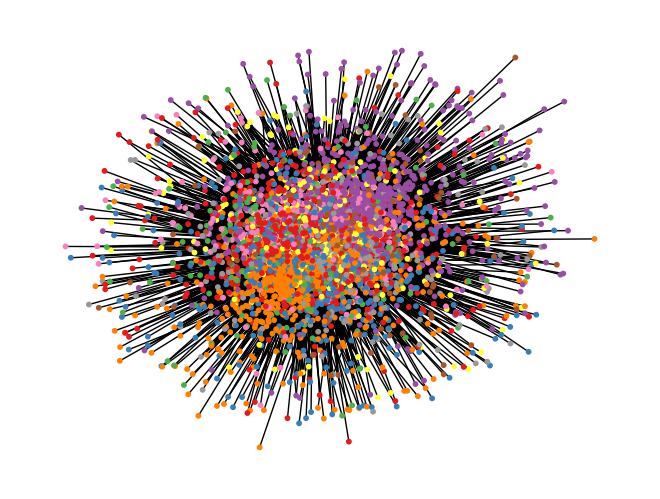

In [14]:
pos = nx.spring_layout(G)  # You can use other layouts like shell_layout, circular_layout, etc.

nx.draw(G, pos, with_labels=False, node_color=node_colors, cmap=plt.cm.Set1, node_size=10, font_size=8, font_color='black')

# Show the plot
plt.show()

To understand the influence of communities, we compute the probability of vote to be within your community if it was voted at random.

In [58]:
n = len(G) # Number of nodes in the graph
p_same_cluster = 0 # Probability that a random vote is an intra-cluster vote
array_p_same_cluster = np.array([])

# We compute the probability that a random vote is an intra-cluster vote
for c in communities:
    p_same_cluster += (len(c)/n)*((len(c)-1)/n)
    array_p_same_cluster = np.append(array_p_same_cluster, (len(c)/n)*((len(c)-1)/n))
print(f"Probability that a random vote is an intra-cluster vote in interaction graph : {p_same_cluster:.2%}")

Probability that a random vote is an intra-cluster vote in interaction graph : 10.80%


# Section 1 <a class="anchor" id="section-1"></a>

In [59]:
# Initialize a counter for votes within the same community
intra_vote_count = np.zeros(len(communities))

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the same community
    for count, community in enumerate(communities):
        if entity1 in community and entity2 in community:
            intra_vote_count[count] += 1

# Print the result
print(f"Number of votes within the same community : {int(intra_vote_count.sum())}")

Number of votes within the same community : 26723


In [60]:
# Initialize a counter for votes in the graph
votes_in_the_graph = 0

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the graph
    if entity1 in G and entity2 in G:
        votes_in_the_graph += 1

# Print the result
print(f"Number of votes in the graph : {votes_in_the_graph}")

Number of votes in the graph : 84741


We compare the probability of a random vote with what was observed. The goal is to assess whether the users vote is influenced by its community. We observe that we have a ~3x increase in probability to vote towards your own community.

In [61]:
print(f"Effective percentage of intra-cluster votes in G: {(intra_vote_count.sum()/votes_in_the_graph):.2%}")

Effective percentage of intra-cluster votes in G: 31.53%


In [62]:
print(f"Number of nodes (users) in the graph : {len(G)}")
print(f"Number of users in the RfA dataset : {len(admin_set)}")
print(f"Percentage of users in the graph : {(len(G)/len(admin_set)):.2%}")

Number of nodes (users) in the graph : 6491
Number of users in the RfA dataset : 11129
Percentage of users in the graph : 58.33%


To understand the increase in votes, we compute the expected number of votes if voted at random. Then we make the ratio to derive the multiplicative coefficient from the expected number of votes to observed. 

In [63]:
# expected number of intra-cluster votes
expected_nb_votes = array_p_same_cluster * votes_in_the_graph

In [64]:
# ratio of effective intra-cluster votes over expected intra-cluster votes
vote_gain = intra_vote_count / expected_nb_votes
vote_gain

array([1.6572912 , 2.09622471, 1.39564435, 5.21656281, 1.54964435,
       4.45891273, 2.67405186, 2.10572832, 3.17360616, 4.36138858,
       3.38287175, 4.90249875, 3.8601127 , 1.33958915, 5.28555286,
       0.703792  , 1.01572686, 6.01449554, 3.02026616])

In [65]:
for i, c in enumerate(communities):
    print(f"Community {i} has size {len(c)}")

Community 0 has size 302
Community 1 has size 276
Community 2 has size 76
Community 3 has size 153
Community 4 has size 297
Community 5 has size 450
Community 6 has size 107
Community 7 has size 966
Community 8 has size 95
Community 9 has size 171
Community 10 has size 1437
Community 11 has size 161
Community 12 has size 728
Community 13 has size 364
Community 14 has size 92
Community 15 has size 540
Community 16 has size 89
Community 17 has size 32
Community 18 has size 155


We want to understand the distribution of votes between communities. For that we plot the distribution of votes between communities

In [66]:
# Number of votes across communities
vote_count_matrix = np.zeros((len(communities), len(communities)))
nb_community_votes = np.zeros(len(communities))

In [67]:
# Populate the vote count matrix
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        vote_count_matrix[i_src][i_dst] += 1
        nb_community_votes[i_src] += 1

In [68]:
# We verify our computations and transform the vote count matrix into a ratio matrix
np.testing.assert_array_equal(vote_count_matrix.sum(axis=1), nb_community_votes)
ratio_vote_count_matrix = (vote_count_matrix / nb_community_votes[:, np.newaxis])*100 
np.testing.assert_almost_equal(ratio_vote_count_matrix.sum(axis=1), np.ones(len(communities))*100)

In the plot we observe that the destination communities that recieve most of the votes are the larger communities. This is explained by the fact that for large communities, more votation take place and therefore more votes are directed to them.

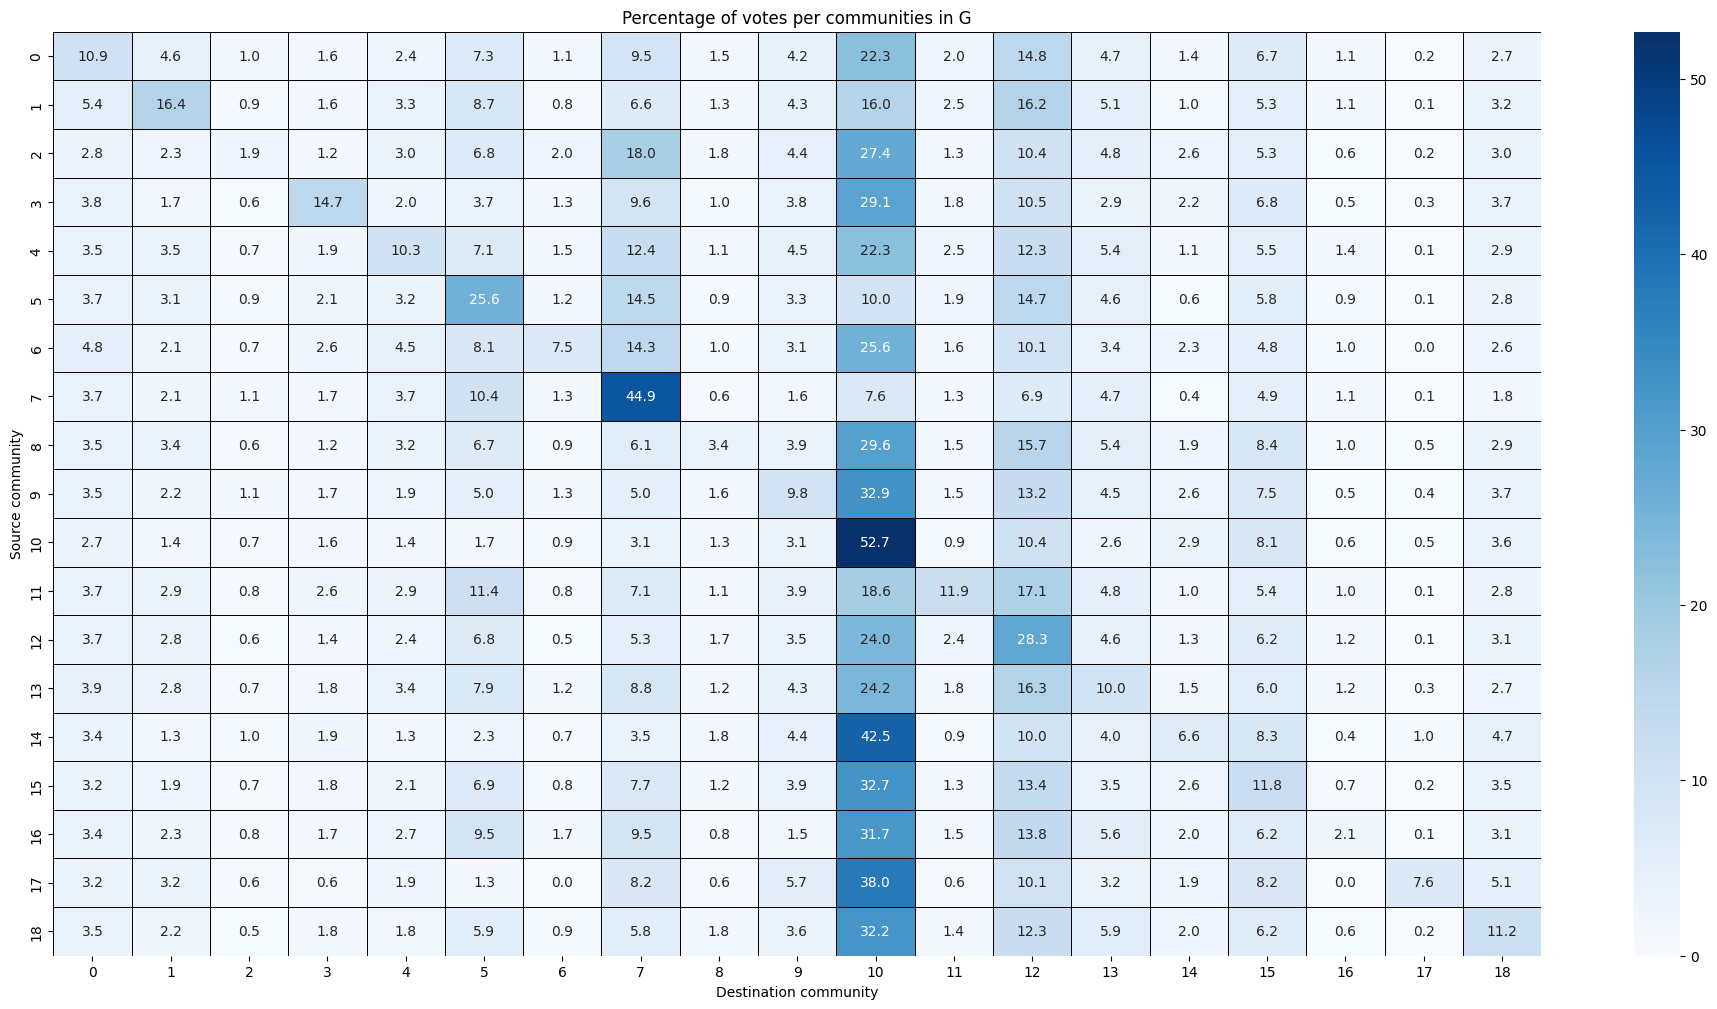

In [69]:
# Heatmap of the ratio of votes across communities
plt.figure(figsize=(24, 12))
sns.heatmap(ratio_vote_count_matrix, cmap="Blues", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

To mitigate this domination of the large communities, we scale the results by the probability of a vote between two communities given that the votes are random. We display the ratio of effective votes over expected votes for each pair of communities.

In [70]:
# Create matrix that represents the probability of a vote between two communities
prob_vote_community_matrix = np.zeros((len(communities), len(communities)))
for i_src in range(len(communities)):
    for i_dst in range(len(communities)):
        prob_vote_community_matrix[i_src][i_dst] = (len(communities[i_src])*len(communities[i_dst]))/(len(G)**2)
# create matrix that represents the expected number of votes between two communities
ratio_vote_expected_matrix = prob_vote_community_matrix * votes_in_the_graph

In [71]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [72]:
gain_vote_expected_matrix = np.nan_to_num(nb_result_votes / ratio_vote_expected_matrix)

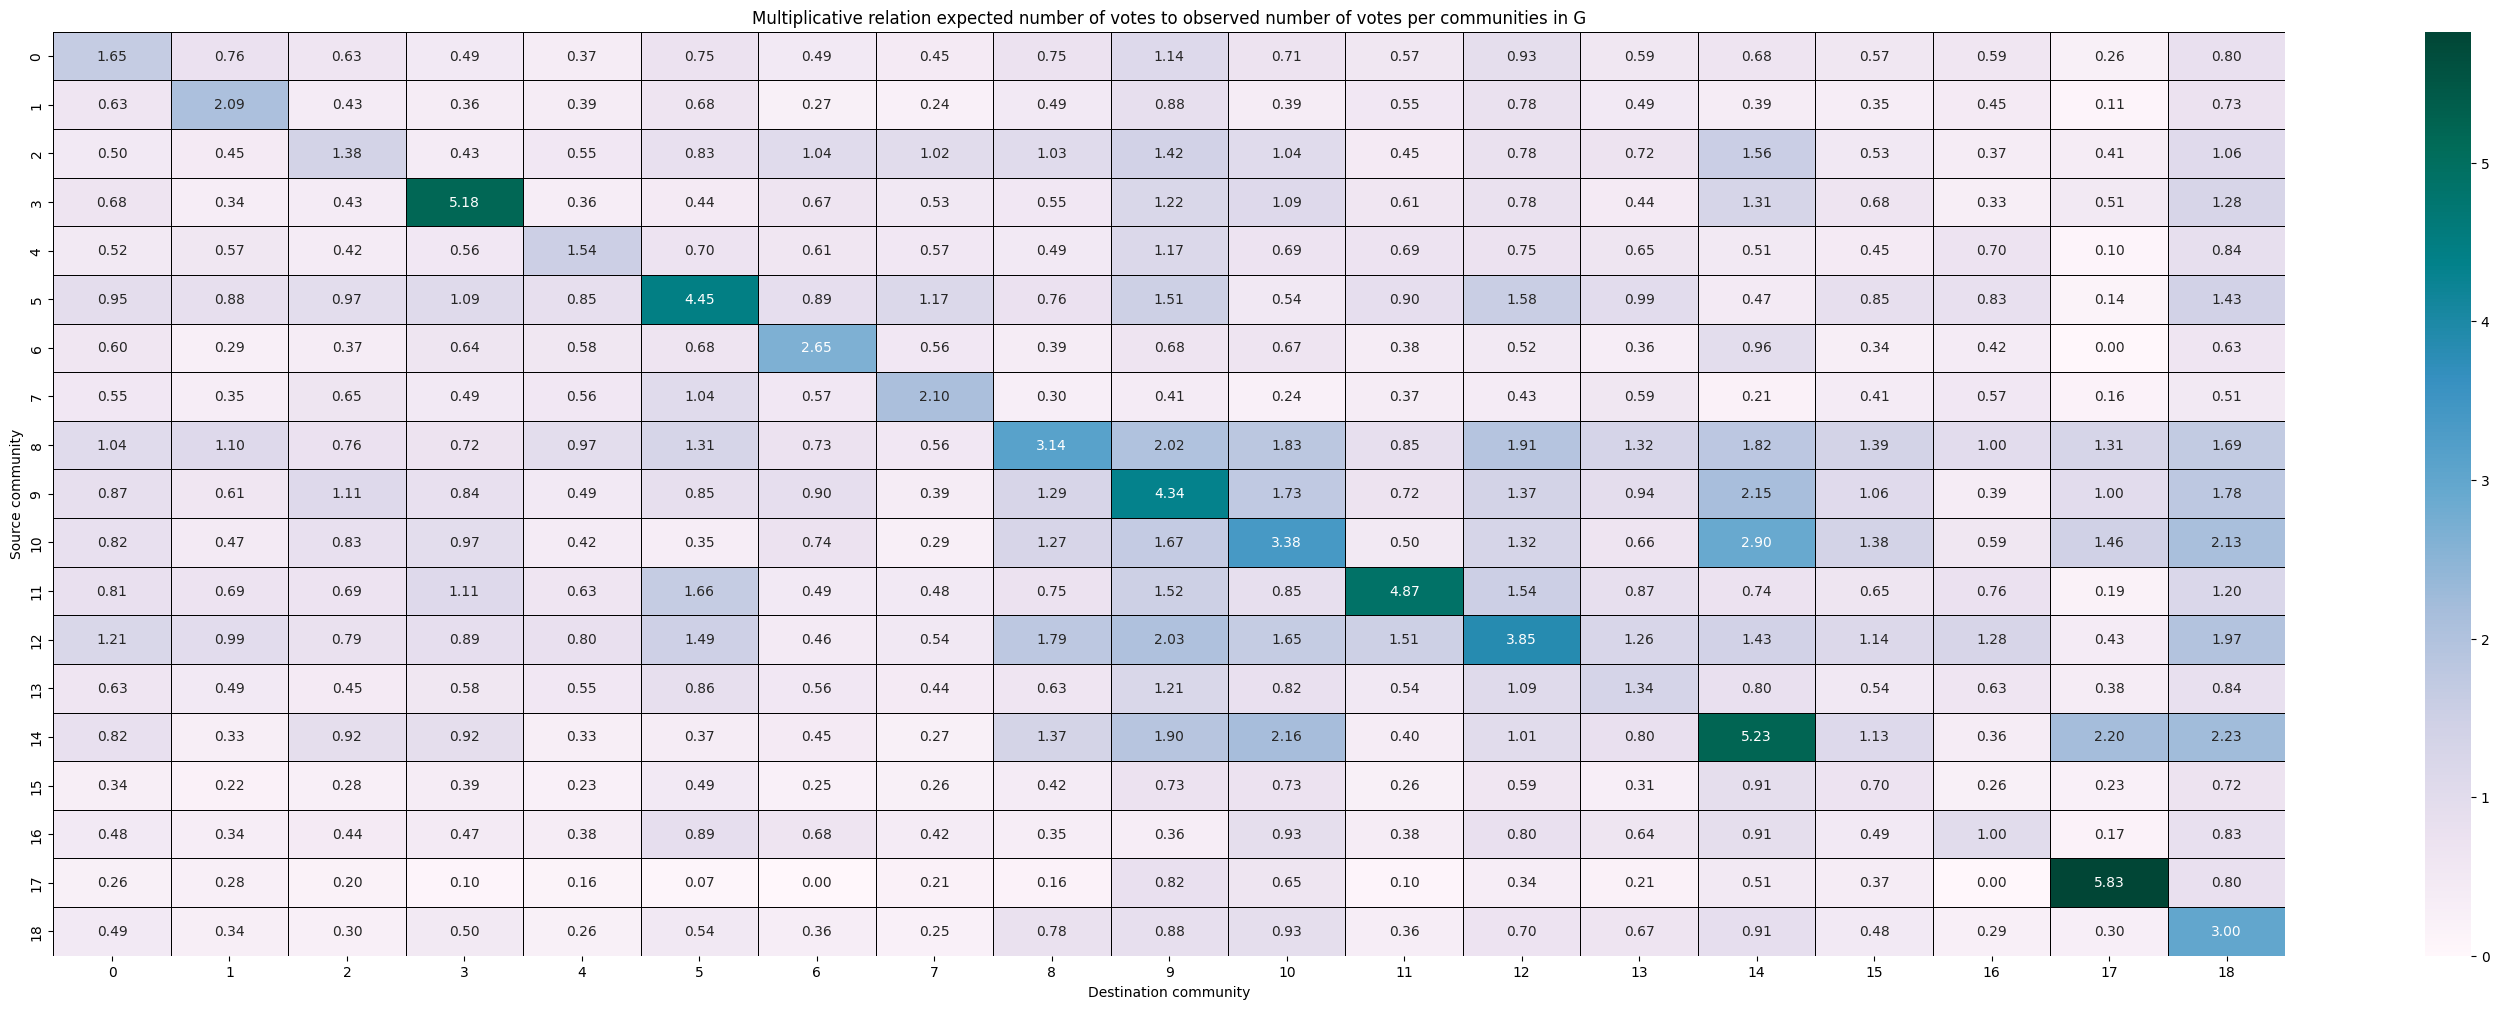

In [73]:
# Heatmap of the gain from expected votes across communities
# Couleurs sympas: 'PuBuGn', 'RdYlBu', 'coolwarm'
plt.figure(figsize=(36, 12))
sns.heatmap(gain_vote_expected_matrix, cmap='PuBuGn', annot=True, fmt=".2f", linewidths=.5, linecolor="black")
plt.title("Multiplicative relation expected number of votes to observed number of votes per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

The diagonal of the matrix has significantly higher values. This indicates that people tend to vote more for the people part of their community. We recall that the communities have been created with the interactions between the users and not the votes.

#### Can we find a rivalry between some communities? Maybe a community only vote negatively towards another community.

We want to know the voting habitudes of communities. For that we plot the result precentage per community

In [74]:
# populate the matrix of votes
vote_result_matrix = [[np.zeros(3) for i in range(len(communities))] for j in range(len(communities))]
nb_result_votes = np.zeros((len(communities), len(communities)))
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']
    if entity1 in G and entity2 in G:
        i_src = find_community(entity1, communities)
        i_dst = find_community(entity2, communities)
        if row['vote'] == 1:
            vote_result_matrix[i_src][i_dst][2] += 1
        elif row['vote'] == -1:
            vote_result_matrix[i_src][i_dst][0] += 1
        else:
            vote_result_matrix[i_src][i_dst][1] += 1
        nb_result_votes[i_src][i_dst] += 1


In [75]:
vote_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100

/var/folders/4z/k7wkc9t97453h4tqprj_1j3h0000gn/T/ipykernel_41965/1177325575.py:1: RuntimeWarning: invalid value encountered in divide
  vote_result_matrix = np.nan_to_num((vote_result_matrix / nb_result_votes[:,:,np.newaxis]))*100


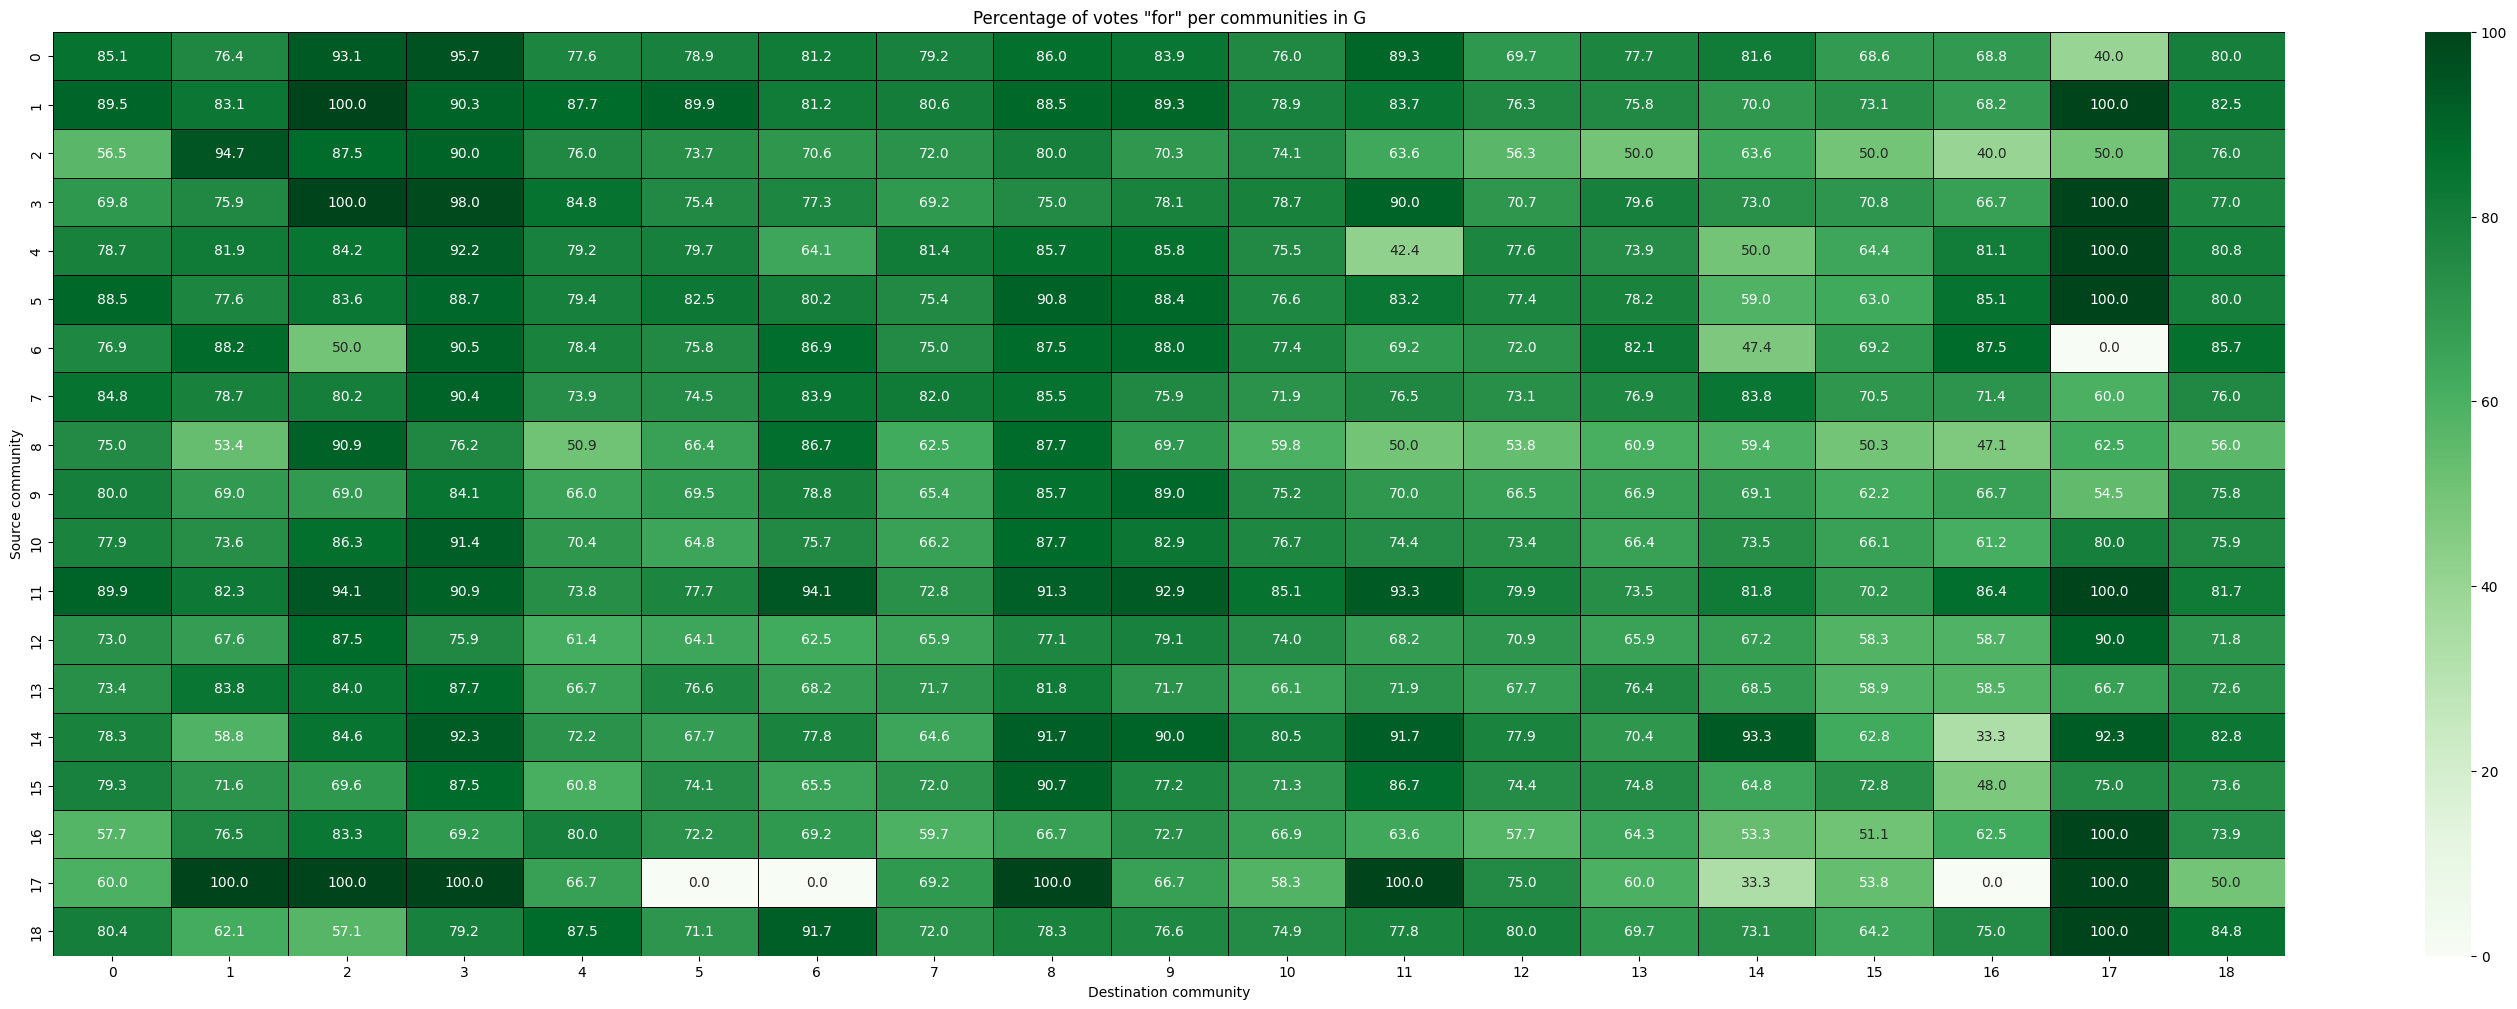

In [76]:
for_ratio_result_matrix = vote_result_matrix[:,:,2]
plt.figure(figsize=(36, 12))
sns.heatmap(for_ratio_result_matrix, cmap="Greens", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"for\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

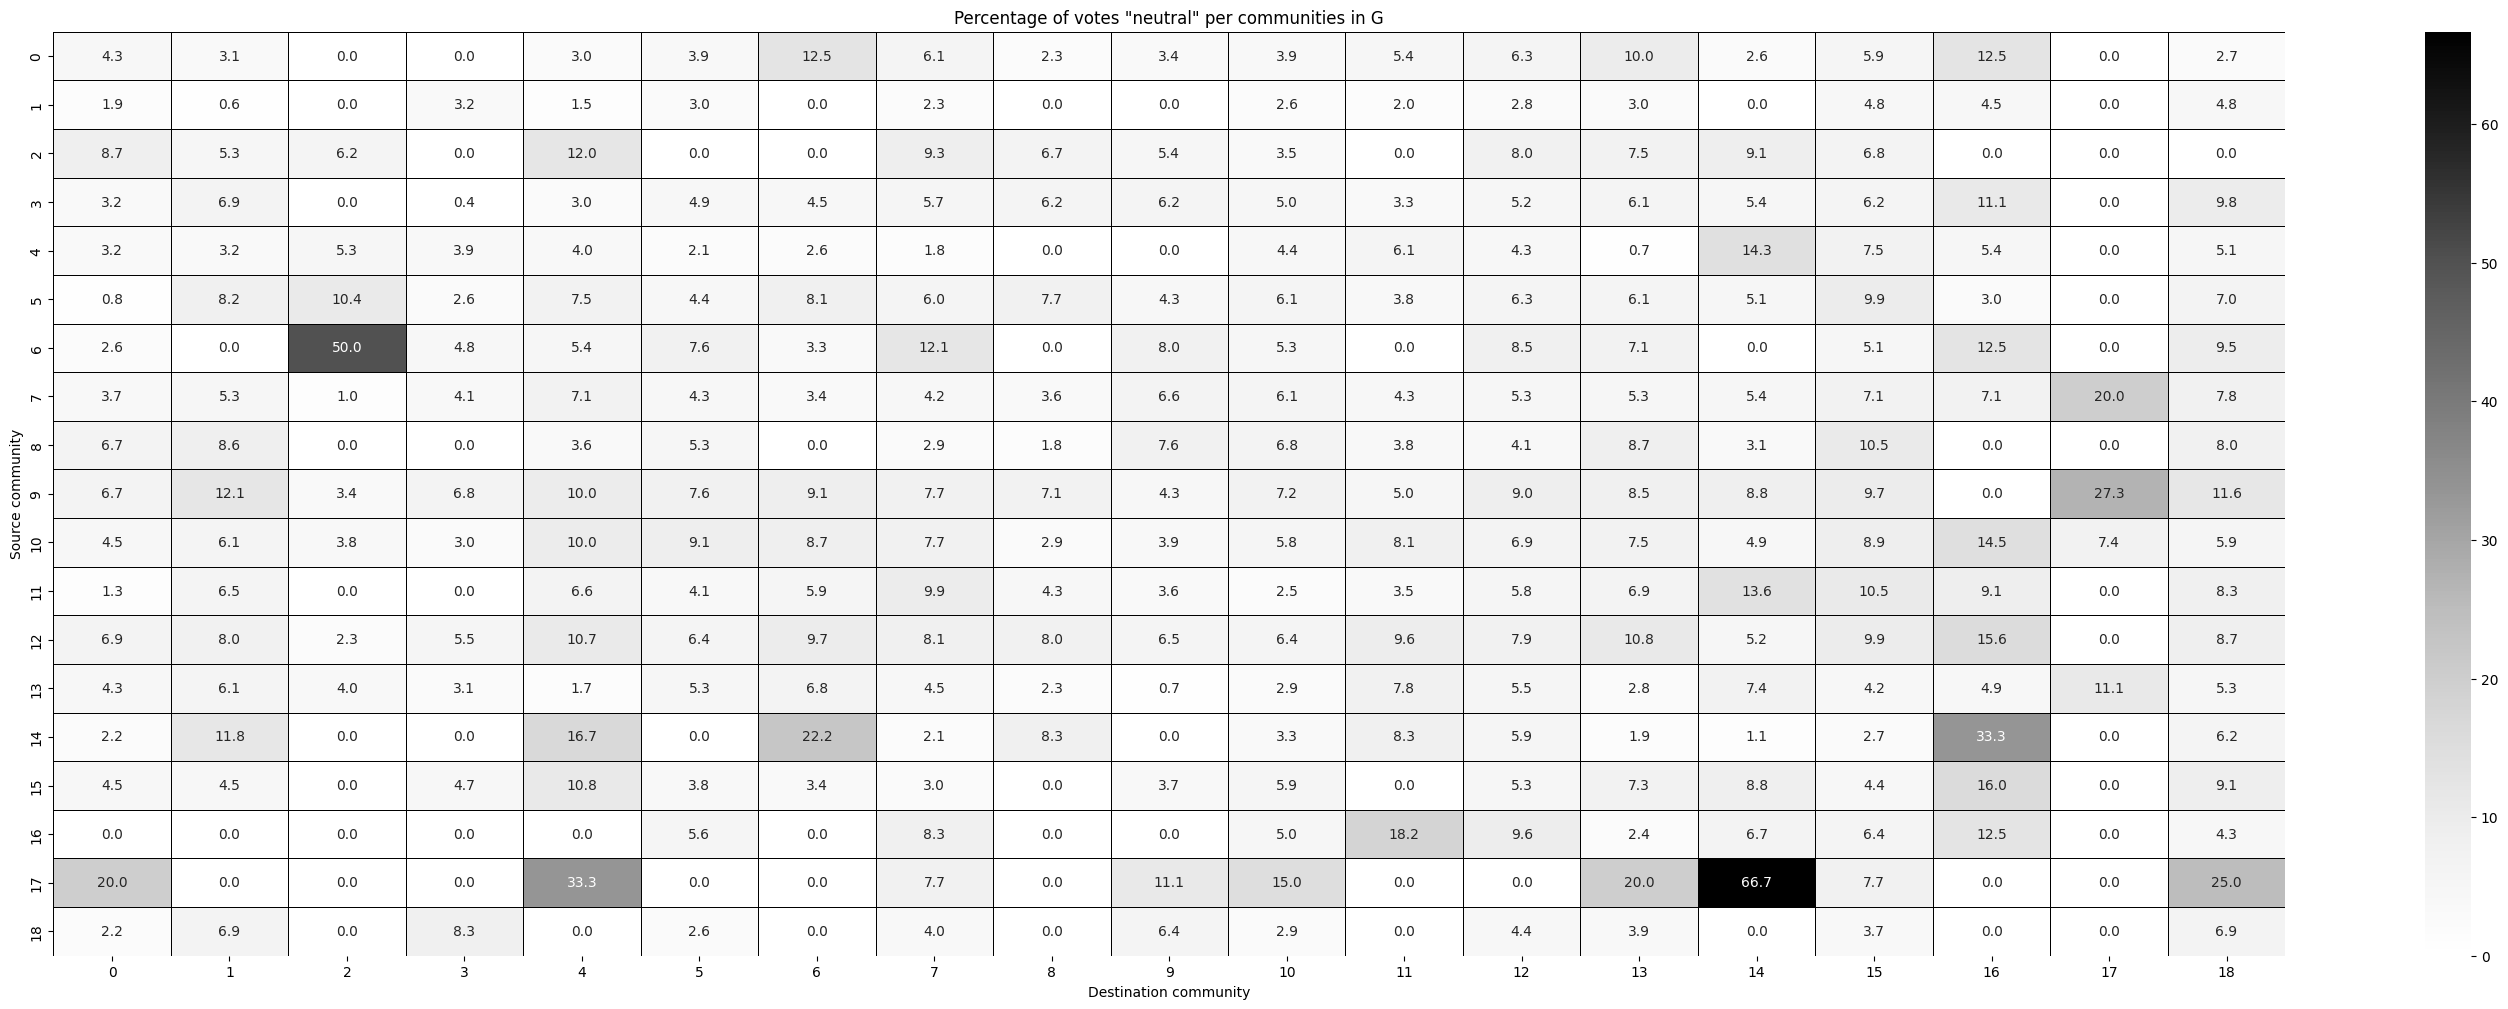

In [77]:
neutral_ratio_result_matrix = vote_result_matrix[:,:,1]
plt.figure(figsize=(36, 12))
sns.heatmap(neutral_ratio_result_matrix, cmap="Greys", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"neutral\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

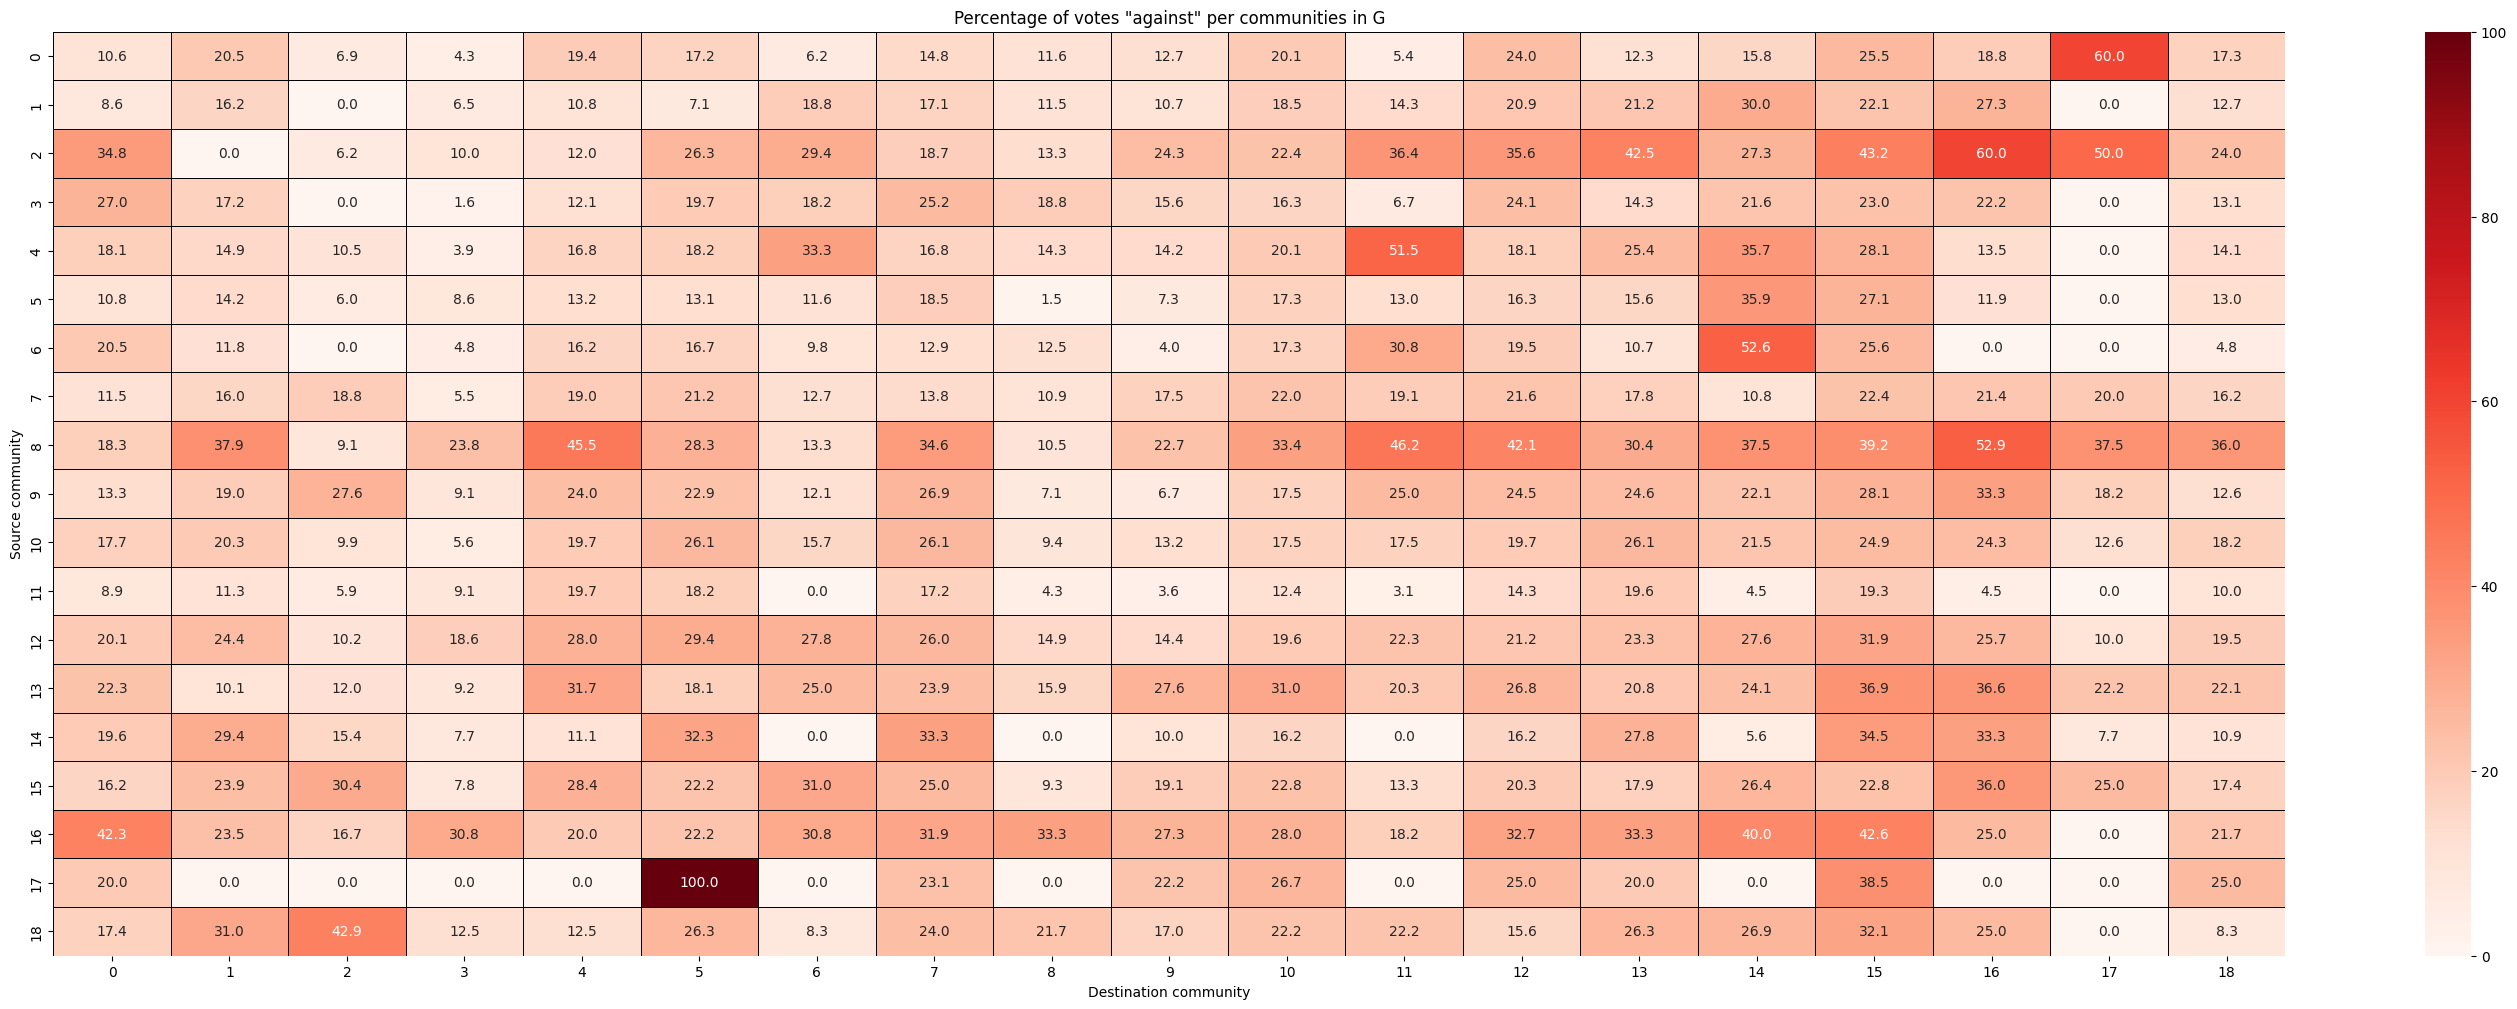

In [78]:
against_ratio_result_matrix = vote_result_matrix[:,:,0]
plt.figure(figsize=(36, 12))
sns.heatmap(against_ratio_result_matrix, cmap="Reds", annot=True, fmt=".1f", linewidths=.5, linecolor="black")
plt.title("Percentage of votes \"against\" per communities in G")
plt.xlabel("Destination community")
plt.ylabel("Source community")
plt.show()

# Content of edits analysis <a class="anchor" id="edits"></a>

**This section explores the relationship between the topics of Wikipedia pages edited by users and the occurrence of votes between two users. The goal is to identify potential correlations and patterns that would show that editing similar topics has an influence in the motivation to cast a vote.**

In [79]:
# The original dataset can be found here (https://snap.stanford.edu/data/wiki-meta.html). 
# The version that we use here has already been modified so that we get each user and 
# the page they modified with the number of edits

edits_df = pd.read_csv("../data/interactions_edits_grouped.zip", index_col=0, compression='zip')
edits_df

,username,counts
article_title,,
!,MPerel,1
!!,Gracenotes,1
!!,Gwern,1
!!,JHunterJ,8
!!,Kane5187,1
...,...,...
ﻲ,Dbenbenn,1
ﻳ,Dbenbenn,1
ﻴ,Dbenbenn,1


In [80]:
# We create a list of Wikipedia pages modified by each users
user_indices = edits_df.groupby('username').apply(lambda x: x.index.tolist()).reset_index(name='Indices')
user_indices

,username,Indices
0,'sed,"[Bloody_Mary_(South_Park), Cartoon_Wars_Part_I..."
1,(.Y.),"[Blue_Water_High, List_of_bass_guitarists, Lis..."
2,(:Julien:),"[1993_Russian_constitutional_crisis, 1999_NBA_..."
3,(aeropagitica),"['Aho'eitu, 'Ilaheva, ...Und_Morgen_Fliegen_Wi..."
4,*Kat*,"[&_Yet_&_Yet, *MTV, .nc.tr, 1670, 1964_(emulat..."
...,...,...
6586,^demon,"[""Comedy_Time""_Ganesh, ""Them""_(King_Diamond_al..."
6587,~K,"[(Bis(trifluoroacetoxy)iodo)benzene, 1,2,4-Tri..."
6588,Вasil,"[1809, 1870, 1877, 1964_Minnesota_Twins_season..."
6589,Еdit,"[1600_Pennsylvania_Avenue_(musical), 2005_Atla..."


In [81]:
# Create a list of all users present in the edits dataset
users = set(edits_df['username'].tolist())

#### Create a matrix with the Jaccard index (on the the lists of modified pages) for all pairs of users

In [82]:
matrix_similarity = pd.read_csv("../data/jaccard.csv.zip", index_col=0, compression='zip')
matrix_similarity

,Bellhalla,Complainer,Werdan7,Grön,Weasel,Filll,Thejerm,Cyclone1,RJFJR,Mkweise,...,UtherSRG,Pyrop,AngelOfSadness,Clarkk,Appleboy,Voyaging,JLaTondre,InShaneee,Ed,Advanced
Bellhalla,1.000000,0.000173,0.000808,0.000000,0.000000,0.000579,0.000315,0.000173,0.001307,0.000426,...,0.001782,0.000296,0.001437,0.000543,0.000334,0.000000,0.004429,0.001600,0.000168,0.000000
Complainer,0.000173,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000492,0.000000,0.000369,0.000000,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000
Werdan7,0.000808,0.000000,1.000000,0.000000,0.000000,0.001804,0.000000,0.000000,0.000596,0.002238,...,0.001802,0.002651,0.008425,0.000504,0.009511,0.002049,0.002832,0.006304,0.004392,0.005298
Grön,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000104,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003106,0.000000,0.000196,0.000324,0.000000,0.000000
Weasel,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000195,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Voyaging,0.000000,0.000000,0.002049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003484,1.000000,0.000197,0.000327,0.004348,0.000000
JLaTondre,0.004429,0.000098,0.002832,0.000196,0.000195,0.001678,0.002697,0.000000,0.005550,0.004555,...,0.008998,0.002688,0.009551,0.002571,0.002116,0.000197,1.000000,0.011813,0.000676,0.000959
InShaneee,0.001600,0.000000,0.006304,0.000324,0.000000,0.004031,0.003552,0.000644,0.005090,0.007861,...,0.007856,0.006660,0.014829,0.001686,0.009451,0.000327,0.011813,1.000000,0.001847,0.001505
Ed,0.000168,0.000000,0.004392,0.000000,0.000000,0.000711,0.000000,0.000000,0.000408,0.001306,...,0.000549,0.001596,0.001755,0.000270,0.006224,0.004348,0.000676,0.001847,1.000000,0.002000


Create a DataFrame with all pairs of users and a binary variable that indicates if a vote exists for each pair.

In [ ]:
similarity_and_vote = pd.read_csv("../data/jaccard_and_votes.csv.zip", index_col=0, compression='zip')
similarity_and_vote

### Now we compute some statistics on this relation.

In [ ]:
pearsonr(similarity_and_vote['vote'], similarity_and_vote['jaccard'])

The correlation between similarity score on edited pages and the votes is not very strong but positive with high significance. 

In [ ]:
# Mean similarity between all pairs of users
mean_sim_all = similarity_and_vote['jaccard'].mean()
mean_sim_all

In [ ]:
# Mean similarity between pairs of users that are linked by a vote
mean_sim_vote = similarity_and_vote[similarity_and_vote['vote'] == 1]['jaccard'].mean()
mean_sim_vote

In [ ]:
print(f"People that are linked by a vote have {mean_sim_vote / mean_sim_all:.2f} times more common edited pages than the average.")

##### Now we investigate the most edited pages of the communities

In [ ]:
for count, community in enumerate(communities):
    community_to_check = community
    
    user_list = list(user_indices['username'])
    all_subject = set()
    for user in community_to_check:
        if user in user_list:
            all_subject = set(user_indices[user_indices['username'] == user]['Indices'].iloc[0]).union(all_subject)
            
    data = pd.DataFrame(index=list(all_subject), columns=['count'])
    data = data.fillna(0)
    
    for user in community_to_check:
        if user in user_list:
            subjects = user_indices[user_indices['username'] == user]['Indices'].iloc[0]
            for s in subjects:
                data.at[s, 'count'] += 1
    print(f"Community {count}:")            
    print(data.sort_values('count', ascending = False).head(20))

In [ ]:
for i, c in enumerate(communities):
    print(f"Community {i} has size {len(c)}")